<a href="https://colab.research.google.com/github/Isak-Petrin/distributional_RL_python/blob/main/Welcome_to_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:192: SyntaxWarning: invalid escape sequence '\l'
<>:193: SyntaxWarning: invalid escape sequence '\l'
<>:192: SyntaxWarning: invalid escape sequence '\l'
<>:193: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3989190572.py:192: SyntaxWarning: invalid escape sequence '\l'
  axs[0].plot(range(step),loss_lst[agent],label = f'$\lambda$ = {agent.l}')
/tmp/ipython-input-3989190572.py:193: SyntaxWarning: invalid escape sequence '\l'
  axs[1].plot(range(step), mean_lst[agent],label = f'$\lambda$ = {agent.l}')
100%|██████████| 1000/1000 [00:07<00:00, 139.43it/s]


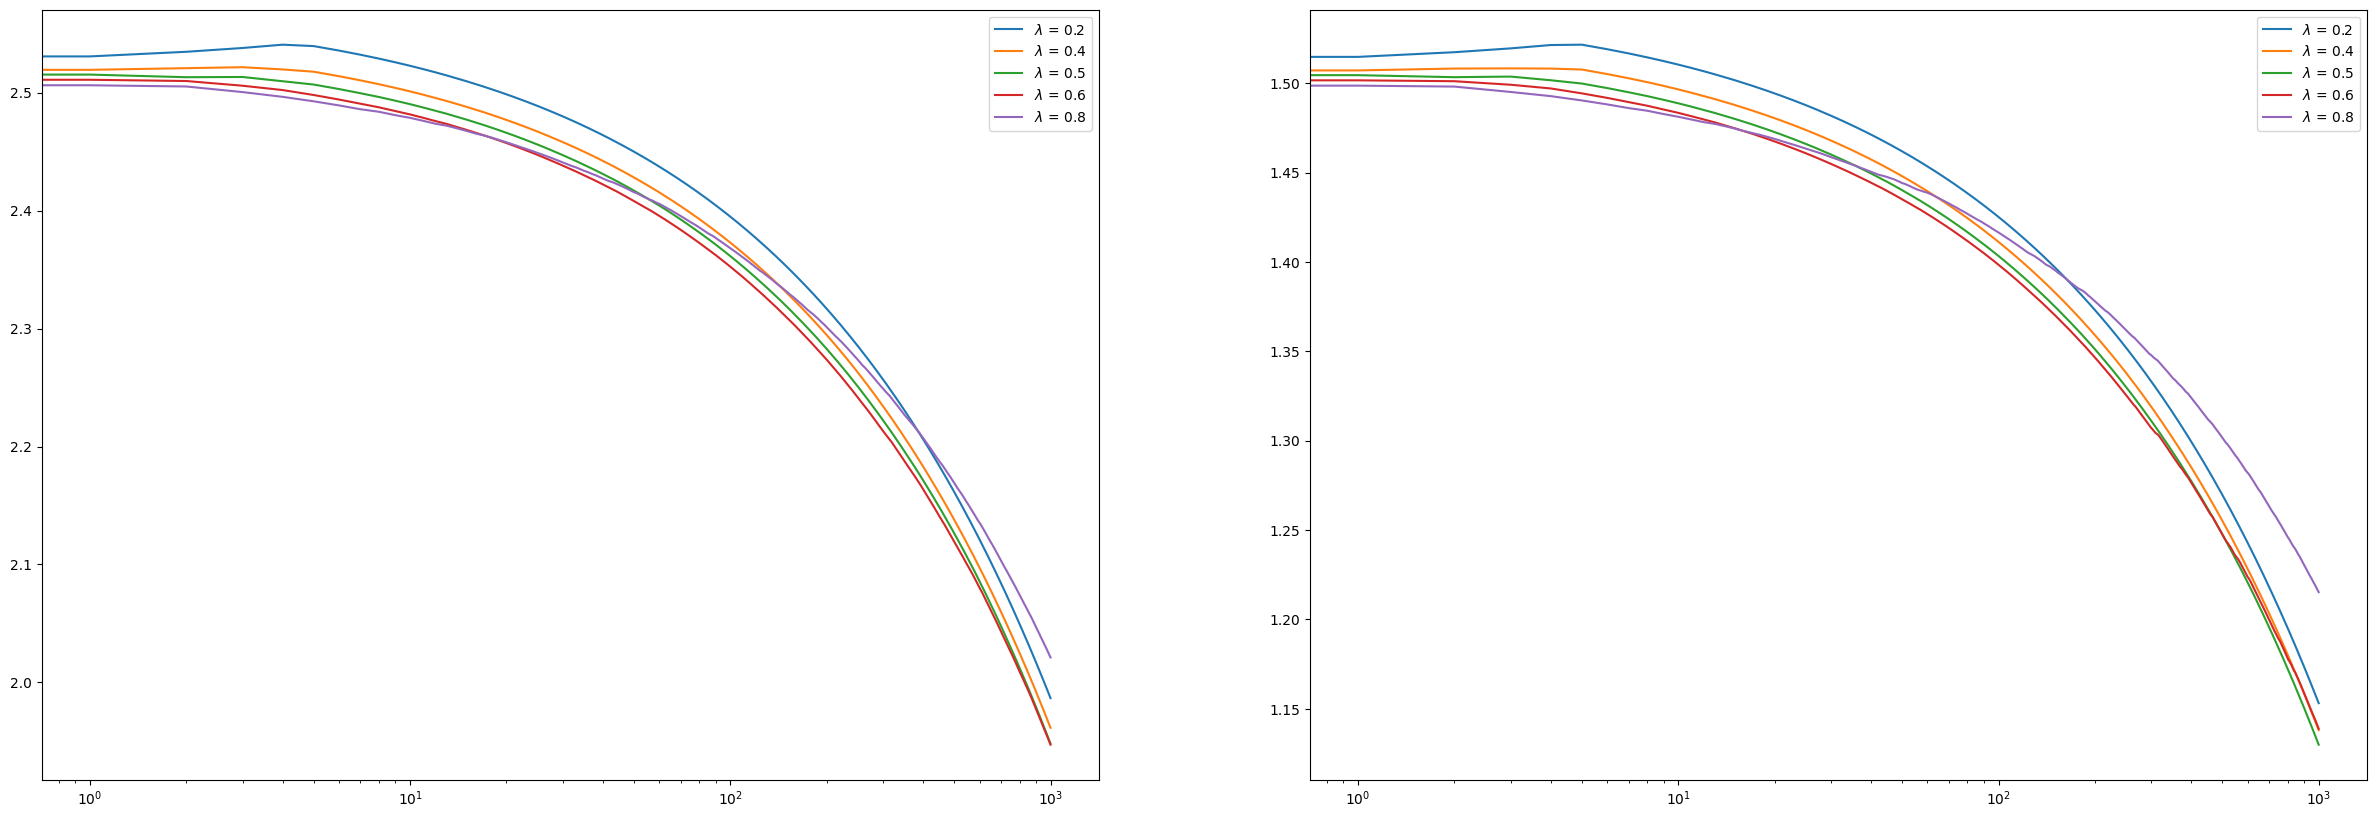

In [18]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.signal import savgol_filter
class quantile:
    def __init__(self, m: int):
        self.m = m
        self.theta = np.linspace(-2,-1,self.m)

    def get_theta(self):
        return self.theta
    def set_theta(self,theta):
        self.theta = theta
    def add_theta(self, diff):
        self.theta += diff
    def sample(self):
        return np.random.choice(self.theta)
    def mean(self):
        return np.mean(self.theta)

class container:
    def __init__(self, x0):
        self.hist = []
        self.xs = [x0]
        self.rs = []
        self.ds = [False]

    def add(self, obs: tuple):
        self.hist.append(obs)
        self.xs.append(obs[0])
        self.rs.append(obs[1])
        self.ds.append(obs[2])

    def get_xs(self):
        return self.xs
    def get_rs(self):
        return self.rs
    def get_x(self,t):
        return self.xs[t]
    def get_d(self,t):
        return self.ds[t]

    def reset(self, x0):
        self.hist = []
        self.xs = [x0]
        self.rs = []
        self.ds = []


class QRTDlAgent:
    def __init__(self, m: int, l: float ,obs_space: int, gamma: float, alpha: float, x0, bootstrap: bool):
        self.m = m
        self.l = l
        self.bootstrap = bootstrap
        self.q = {x: quantile(m = self.m) for x in range(obs_space)}
        self.tau = np.asarray([(2*i - 1) / (2*self.m) for i in range(1,self.m+1)])
        self.gamma = gamma
        self.N = {x: 0 for x in range(obs_space)}
        self.container = container(x0=x0)
        self.trace = lambda s: (1 - self.l) * self.l**(s - 1)
        self.t = 0
        self.alpha0 = alpha
        self.episode = 0

    def reset(self,x0):
        self.t = 0
        self.container.reset(x0)
    def get_mean(self,x):
        return self.q[x].mean()

    def get_ds(self,t):
        return self.container.get_d(t)

    def get_q(self, x):
        return self.q[x]
    def get_xt(self,t):
        x = self.container.get_x(t = t)
        return x,self.q[x].get_theta()

    def current_alpha(self):
        return np.exp(-self.episode * 1e-4)

    def get_theta(self, x):
        return self.q[x].get_theta()

    def add_diff(self, x, diff):
        self.q[x].add_theta(diff)

    def get_tau(self):
        return self.tau

    def project_monotone(self, x):
        theta = self.q[x].get_theta()
        theta = np.maximum.accumulate(theta)
        self.q[x].set_theta(theta)

    def store(self,x,r, done):
        self.container.add((x,r,done))

    def update(self,x,r,done: bool):
        self.t += 1
        self.store(x,r,done)

        for i in range(self.t):
            h = self.t - i
            target = self.get_target(t = i, h = h)
            x,theta = self.get_xt(t = i)
            self.N[x] += 1
            alpha_t = self.alpha0 / np.sqrt(self.N[x] + 1e-8)
            trc = self.trace(s = h)
            grad = np.zeros(self.m)
            alpha = self.current_alpha()
            if self.bootstrap:
                less = (target < theta)
                grad = self.m * alpha_t * trc * (self.tau - less)
            else:
                less = target[None, :] < theta[:, None]
                counts = less.sum(axis=1)
                grad = (alpha_t / self.m) * trc * (self.m * self.tau - counts)
            self.add_diff(x = x, diff = grad)
            self.project_monotone(x)


    def get_target(self, t,h):
        rs = self.container.get_rs()
        xb = self.container.get_x(t = t+h)
        if self.bootstrap:
            target = 0
            for i,k in enumerate(range(t,t+h)):
                target += self.gamma**i * rs[k]
                if self.get_ds(t = k) == True:
                    return target
            return target + self.q[xb].sample() * self.gamma**h
        else:
            target = np.zeros(self.m)
            for i,k in enumerate(range(t,t+h)):
                target += self.gamma**i * np.ones(self.m) * rs[k]
                if self.get_ds(t = k) == True:
                    return target
            return target + self.get_theta(xb) * self.gamma**h
step = 100000
gamma = 1
alpha = 0.1
length = 8
bootstrap = False
s = np.random.normal(size=step) * gamma**(length-1)
m = 3
taus = [(2*i - 1) / (2*m) for i in range(1,m+1)]
emp = [np.quantile(s, tau) for tau in taus]


x0 = 0
agent1 = QRTDlAgent(m = m,obs_space=length,l = .2 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap)
agent2 = QRTDlAgent(m = m,obs_space=length,l = .4 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap)
agent3 = QRTDlAgent(m = m,obs_space=length,l = .5 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap)
agent4 = QRTDlAgent(m = m,obs_space=length,l = .6 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap)
agent5 = QRTDlAgent(m = m,obs_space=length,l = .8 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap)


agent_lst = [agent1,agent2]

loss_lst = {agent: [] for agent in agent_lst}
mean_lst = {agent: [] for agent in agent_lst}

fig,axs = plt.subplots(1,2,figsize = (30,10))

for episode in tqdm(range(step)):

    r = np.random.normal()
    obs_lst = [(i+1,r if (i + 1) == (length - 1) else 0, (i+1) == (length - 1)) for i in range(length-1)]

    for obs in obs_lst:
        x,r,done = obs

        for agent in agent_lst:
          agent.update(x = x, r = r, done = done)
          if done == True:
            agent.reset(x0 = x0)
            agent.episode += 1


    for agent in agent_lst:
      est = agent.get_theta(x = 0)
      u = emp-est
      rho = u * (taus - (u < 0))
      total_loss = np.sum(rho)
      loss_lst[agent].append(total_loss)
      mean_lst[agent].append(agent.get_mean(x = 0))

for agent in agent_lst:
    axs[0].plot(range(step), loss_lst[agent], label=f'$\lambda$ = {agent.l}')
    axs[1].plot(range(step), mean_lst[agent], label=f'$\lambda$ = {agent.l}')

axs[0].set_xscale('log')
axs[1].set_xscale('log')

axs[0].set_title('Quantile Regression Loss')
axs[1].set_title('Estimated Mean of Quantiles')

axs[0].set_xlabel('Step')
axs[1].set_xlabel('Step')
axs[0].set_ylabel('Loss')
axs[1].set_ylabel('Mean')

axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.show()
